In [1]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.datasets import cifar10
import numpy as np

Using TensorFlow backend.


In [4]:
# 자동차인것만 선별
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
x_train = X_train[np.where(Y_train==1)[0],:,:,:]
x_test = X_test[np.where(Y_test==1)[0],:,:,:]
y_train = Y_train[np.where(Y_train==1)[0]]
y_test = Y_test[np.where(Y_test==1)[0]]
print('[Total         ] X_train:{}    Y_train:{}    X_test:{}    Y_test:{}'.format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))
print('[Label1(자동차)] x_train:{}     y_train:{}    x_test:{}     y_test:{}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

[Total         ] X_train:(50000, 32, 32, 3)    Y_train:(50000, 1)    X_test:(10000, 32, 32, 3)    Y_test:(10000, 1)
[Label1(자동차)] x_train:(5000, 32, 32, 3)     y_train:(5000, 1)    x_test:(1000, 32, 32, 3)     y_test:(1000, 1)


In [9]:
print('x_train[0][0][0] >>> Data:{}    dtype:{}'.format(x_train[0][0][0], x_train[0][0][0].dtype))
x_train_s = x_train.astype('float32')/255
x_test_s  = x_test.astype('float32')/255.
print('x_train_s[0][0][0] >>> Data:{}    dtype:{}'.format(x_train_s[0][0][0], x_train_s[0][0][0].dtype))

x_train[0][0][0] >>> Data:[170 180 198]    dtype:uint8
x_train_s[0][0][0] >>> Data:[0.6666667 0.7058824 0.7764706]    dtype:float32


In [11]:
# 가우시간 노이즈 추가
x_train_n = x_train_s + 0.2 * np.random.normal(loc=0.0, scale=0.4, size=x_train_s.shape)
x_test_n = x_test_s + 0.2 * np.random.normal(loc=0.0, scale=0.4, size=x_test_s.shape)
x_train_n = np.clip(x_train_n, 0., 1.)
x_test_n = np.clip(x_test_n, 0., 1.)
print('[노이즈 적용] x_train_n:{}     x_test_n:{}'.format(x_train_n.shape, x_test_n.shape))
print('x_train_n[0][0][0] >>> Data:{}    dtype:{}'.format(x_train_n[0][0][0], x_train_n[0][0][0].dtype))

[노이즈 적용] x_train_n:(5000, 32, 32, 3)     x_test_n:(1000, 32, 32, 3)
x_train_n[0][0][0] >>> Data:[0.77263451 0.72061868 0.97765732]    dtype:float64


In [12]:
inp_img = Input(shape=(32,32,3))

In [30]:
# TensorFlow 정의
img1 = Conv2D(32, (3,3), activation='relu', padding='same')(inp_img)
img2 = MaxPooling2D((2,2), padding='same')(img1)
img3 = Conv2D(32, (3,3), activation='relu', padding='same')(img2)
img4 = UpSampling2D((2,2))(img3)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(img4)
print('1. Input          Shape : {} '.format(inp_img.shape))
print('2. Conv2D         Shape : {} '.format(img1.shape))
print('3. MaxPooling2D   Shape : {} '.format(img2.shape))
print('4. Conv2D         Shape : {} '.format(img3.shape))
print('5. UpSampling2D   Shape : {} '.format(img4.shape))
print('6. Conv2D(Decode) Shape : {} '.format(decoded.shape))

1. Input          Shape : (?, 32, 32, 3) 
2. Conv2D         Shape : (?, 32, 32, 32) 
3. MaxPooling2D   Shape : (?, 16, 16, 32) 
4. Conv2D         Shape : (?, 16, 16, 32) 
5. UpSampling2D   Shape : (?, 32, 32, 32) 
6. Conv2D(Decode) Shape : (?, 32, 32, 3) 


In [31]:
# 모델 설정
autoencoder = Model(inp_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [32]:
# 텐서보드 설정
tensorboard = TensorBoard(log_dir='./models/autoencoder1',
              histogram_freq=0, write_graph=True, write_images=True)
model_saver = ModelCheckpoint(
                    filepath='./models/autoencoder1/autoencoder_model',
                     verbose=0, period=2)

In [33]:
# 모델 학습
autoencoder.fit(x_train_n, x_train_s, epochs=10,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_n, x_test_s),
                callbacks=[tensorboard, model_saver])  

Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6184 - val_loss: 0.5603
Epoch 2/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.5657 - val_loss: 0.5590
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.5578 - val_loss: 0.5594
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.5536 - val_loss: 0.5435
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.5493 - val_loss: 0.5485
Epoch 6/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.5472 - val_loss: 0.5406
Epoch 7/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.5449 - val_loss: 0.5475
Epoch 8/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.5436 - val_loss: 0.5412
Epoch 9/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.5417 - val_loss: 0.5391
Epoch 10/10
5000/5000 [==

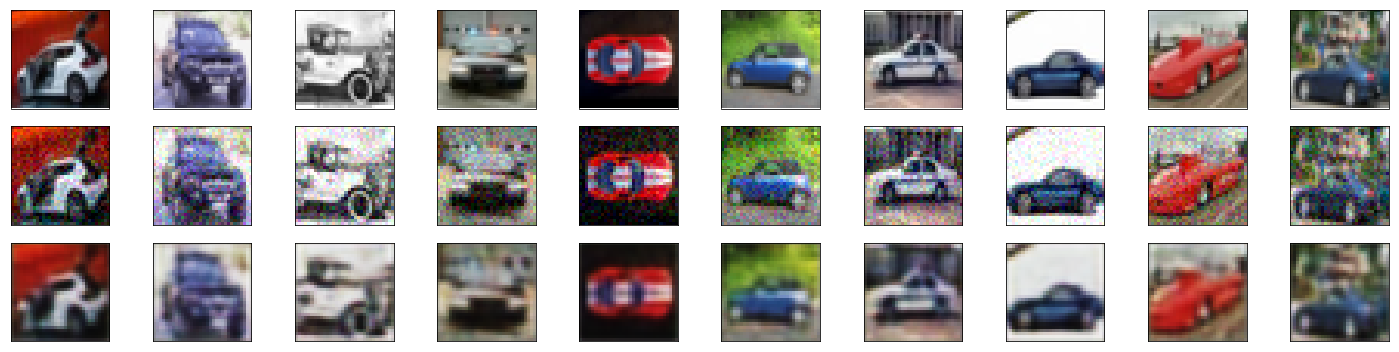

In [34]:
import matplotlib.pyplot as plt
% matplotlib inline
 
n_imgs = 10
f,axarr = plt.subplots(3,n_imgs,figsize=[20,5])
decoded_imgs = autoencoder.predict(x_test_n)
 
for i in range(n_imgs):
     
    ax = axarr[0,i]
    ax.get_yaxis().set_visible(False)
    ax.imshow(x_test_s[i,:,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
     
    ax = axarr[1,i]
    ax.get_yaxis().set_visible(False)
    ax.imshow(x_test_n[i,:,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
             
    ax = axarr[2,i]
    ax.get_yaxis().set_visible(False)
    ax.imshow(decoded_imgs[i,:,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
             
plt.tight_layout()
plt.show()